In [1]:
# Data manipulation
# ==============================================================================
import warnings
import shap
import math
from skforecast.utils import load_forecaster
from skforecast.utils import save_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import skforecast
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset
from IAT_dataparser import IATDataParser

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================


# Warnings configuration
# ==============================================================================
warnings.filterwarnings('once')

print('Skforecast version: ', skforecast.__version__)

c:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\net-pred\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
scapy.loading WARNING Wireshark is installed, but cannot read manuf !


Skforecast version:  0.12.1


In [2]:
# data_path = "../data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Teams/1619005750_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json"
# data_path = '../data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Teams/1619782605_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json'
# data_path = "../data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Teams/1619192105_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json"

# data_path = r"C:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\data\MIRAGE\MIRAGE-COVID-CCMA-2022\Raw_JSON\Teams\Teams\1619005750_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json"
# data_path = r"C:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\data\MIRAGE\MIRAGE-COVID-CCMA-2022\Raw_JSON\Teams\Teams\1619015725_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json"
data_path = r"C:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\data\MIRAGE\MIRAGE-COVID-CCMA-2022\Raw_JSON\Teams\Teams\1619174436_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json"

# Instantiate DataParser class
iat_data_parser = IATDataParser(data_path)

# Reading the biflow data
biflow_data = iat_data_parser.biflow_data

biflows = list(biflow_data.keys())

print("biflows: ", biflows)
print('number of biflows: ', len(biflows))

biflows:  ['192.168.20.111,36819,8.8.8.8,853,6', '192.168.20.111,36826,8.8.8.8,853,6', '192.168.20.111,56908,52.114.92.0,443,6', '192.168.20.111,33830,52.114.76.60,443,6', '192.168.20.111,49889,52.113.194.132,443,6', '192.168.20.111,38547,52.114.92.85,443,6', '192.168.20.111,49891,52.113.194.132,443,6', '192.168.20.111,46700,40.70.161.7,443,6', '192.168.20.111,49893,52.113.194.132,443,6', '192.168.20.111,38315,52.114.92.154,443,6', '192.168.20.111,48035,138.91.136.108,443,6', '192.168.20.111,41169,20.190.160.133,443,6', '192.168.20.111,49897,52.113.194.132,443,6', '192.168.20.111,44914,52.113.199.85,443,6', '192.168.20.111,49899,52.113.194.132,443,6', '192.168.20.111,43083,52.113.194.132,443,6', '192.168.20.111,34321,52.114.92.70,443,6', '192.168.20.111,46689,52.114.104.9,443,6', '192.168.20.111,37911,52.114.104.9,3478,17', '192.168.20.111,34582,52.114.104.9,443,6', '192.168.20.111,50017,52.113.193.5,3478,17', '192.168.20.111,50017,52.114.124.178,3478,17', '192.168.20.111,50022,52.113.

In [3]:
test_IAT = iat_data_parser.generate_debug_set()
test_IAT = iat_data_parser.saturate_99(test_IAT)
test_IAT = iat_data_parser.minmax_scaler(test_IAT)

test_IAT = test_IAT.iloc[900:]
# len(test_IAT)
test_IAT

IAT and payload length different number of elements
IAT and payload length different number of elements


,Interarrival,Interarrival_scaled
900,0.923539,1.682583e-02
901,0.000011,2.004074e-07
902,0.000988,1.800023e-05
903,0.000008,1.457509e-07
904,0.001478,2.692747e-05
...,...,...
2564,0.003999,7.285721e-05
2565,0.002993,5.452904e-05
2566,0.038000,6.923166e-04
2567,0.013003,2.368998e-04


Steps:  333
Train dates : 900 --- 2235  (n=1336)
Test dates  : 2236 --- 2568  (n=333)


c:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\net-pred\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


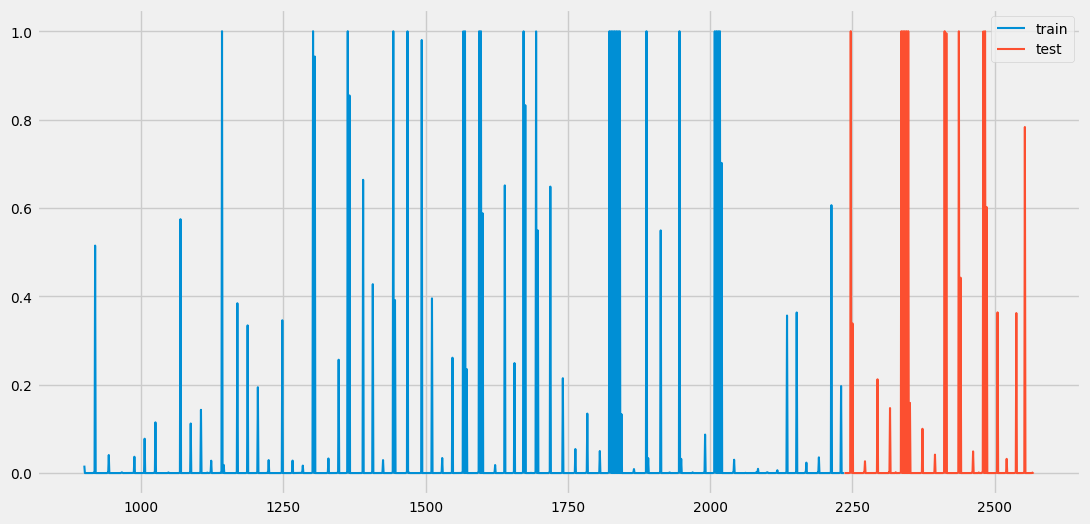

In [4]:
# Split data into train-test
# ==============================================================================
steps = len(test_IAT) * 0.2  # 80/20 split
steps = math.floor(steps)
print("Steps: ", steps)

data_train = test_IAT[:-steps]
data_test = test_IAT[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(12, 6))
data_train['Interarrival_scaled'].plot(ax=ax, label='train')
data_test['Interarrival_scaled'].plot(ax=ax, label='test')
ax.legend()

In [5]:
forecaster = ForecasterAutoreg(
            regressor=RandomForestRegressor(random_state=123),
            lags=101
        )

forecaster.fit(y=data_train['Interarrival_scaled'])

predictions = forecaster.predict(steps=1)

In [6]:
from tqdm import tqdm

def optimal_future_len(data_train, data_test, start, end, step=1):
    losses = []
    future_len = []

    for f_len in tqdm(range(start, end, step)):
        future_len.append(f_len)

        print("future len: ", f_len)
        forecaster = ForecasterAutoreg(
            regressor=RandomForestRegressor(random_state=123),
            lags=101
        )

        forecaster.fit(y=data_train['Interarrival_scaled'])

        predictions = forecaster.predict(steps=f_len)

        error_mse = mean_squared_error(
            y_true=data_test['Interarrival_scaled'].iloc[:f_len],
            y_pred=predictions
        )

        losses.append(error_mse)

    return losses, future_len

  0%|          | 0/17 [00:00<?, ?it/s]

future len:  1


  6%|▌         | 1/17 [00:07<01:56,  7.25s/it]

future len:  21


 12%|█▏        | 2/17 [00:14<01:47,  7.16s/it]

future len:  41


 18%|█▊        | 3/17 [00:21<01:40,  7.17s/it]

future len:  61


 24%|██▎       | 4/17 [00:28<01:33,  7.18s/it]

future len:  81


 29%|██▉       | 5/17 [00:35<01:26,  7.20s/it]

future len:  101


 35%|███▌      | 6/17 [00:43<01:19,  7.22s/it]

future len:  121


 41%|████      | 7/17 [00:50<01:12,  7.28s/it]

future len:  141


 47%|████▋     | 8/17 [00:58<01:06,  7.37s/it]

future len:  161


 53%|█████▎    | 9/17 [01:05<00:59,  7.46s/it]

future len:  181


 59%|█████▉    | 10/17 [01:13<00:52,  7.52s/it]

future len:  201


 65%|██████▍   | 11/17 [01:21<00:45,  7.54s/it]

future len:  221


 71%|███████   | 12/17 [01:28<00:37,  7.59s/it]

future len:  241


 76%|███████▋  | 13/17 [01:36<00:30,  7.63s/it]

future len:  261


 82%|████████▏ | 14/17 [01:44<00:23,  7.67s/it]

future len:  281


 88%|████████▊ | 15/17 [01:52<00:15,  7.71s/it]

future len:  301


 94%|█████████▍| 16/17 [01:59<00:07,  7.76s/it]

future len:  321


100%|██████████| 17/17 [02:08<00:00,  7.54s/it]


Lags:  [1, 21, 41, 61, 81, 101, 121, 141, 161, 181, 201, 221, 241, 261, 281, 301, 321]


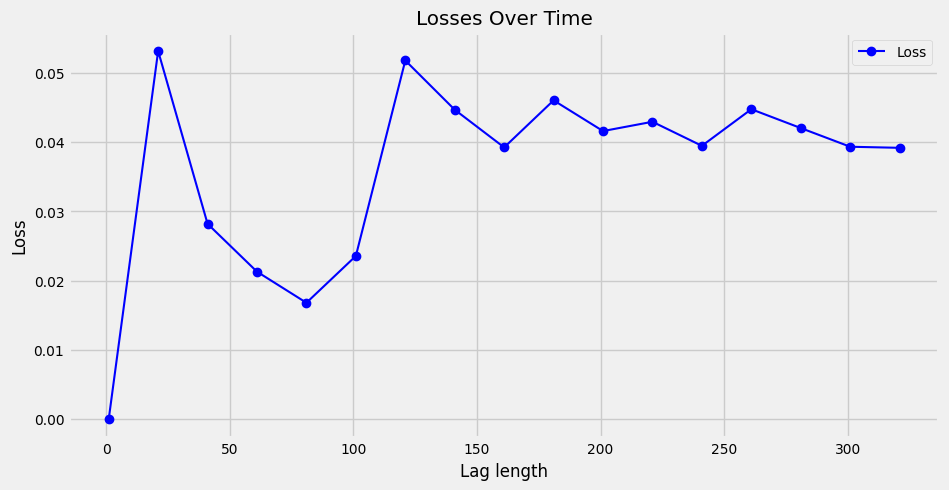

In [7]:
losses, future_len = optimal_future_len(data_train, data_test, 1, len(data_test), 20)

print("Lags: ", future_len)
# lags = list(range(steps, len(data_train), 10))

# Ensure the length of losses matches the length of lags
if len(losses) != len(future_len):
    raise ValueError(
        "The length of losses must match the number of lags generated by the specified range.")

plt.figure(figsize=(10, 5))
plt.plot(future_len, losses, marker='o', linestyle='-', color='b', label='Loss')
plt.title('Losses Over Time')
plt.xlabel('Lag length')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [12]:
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    # lags=get_lag_list(steps, 0)
    lags=101
)
forecaster.fit(y=data_train['Interarrival_scaled'])
forecaster


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101] 
Transformer for y: None 
Transformer for exog: None 
Window size: 101 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [900, 2235] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decr

In [13]:
min_future = future_len.index(min(future_len))
print("min loss future length: ", min_future)

print("Steps: ", steps)
predictions = forecaster.predict(steps=81)
predictions.head(5)

min loss future length:  0
Steps:  333


2236    0.000057
2237    0.000039
2238    0.000072
2239    0.000025
2240    0.000101
Name: pred, dtype: float64

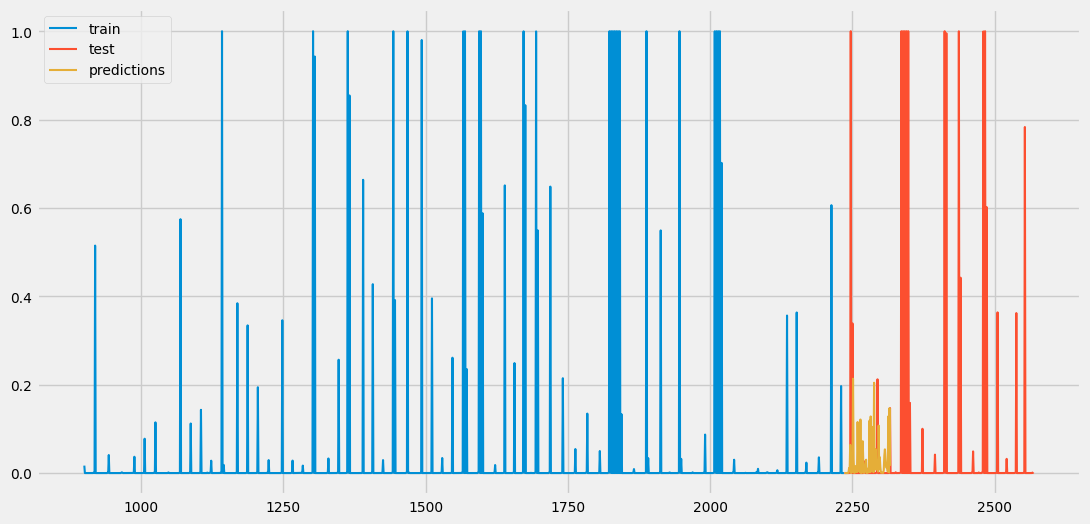

In [14]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
data_train['Interarrival_scaled'].plot(ax=ax, label='train')
data_test['Interarrival_scaled'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [15]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
    y_true=data_test['Interarrival_scaled'].iloc[:81],
    y_pred=predictions
)
print(f"Optimal Gap Test error (MSE): {error_mse}")

Optimal Gap Test error (MSE): 0.01680211918716968


In [16]:
forecaster_base = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    # lags=get_lag_list(steps, 0)
    lags=101
)
forecaster_base.fit(y=data_train['Interarrival_scaled'])
forecaster_base


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101] 
Transformer for y: None 
Transformer for exog: None 
Window size: 101 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [900, 2235] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decr

In [ ]:
# Predictions
# ==============================================================================
# steps = 80
print("Steps: ", steps)
predictions_base = forecaster_base.predict(steps=steps)
predictions_base.head(5)

Steps:  333


2236    0.000057
2237    0.000039
2238    0.000072
2239    0.000025
2240    0.000101
Name: pred, dtype: float64

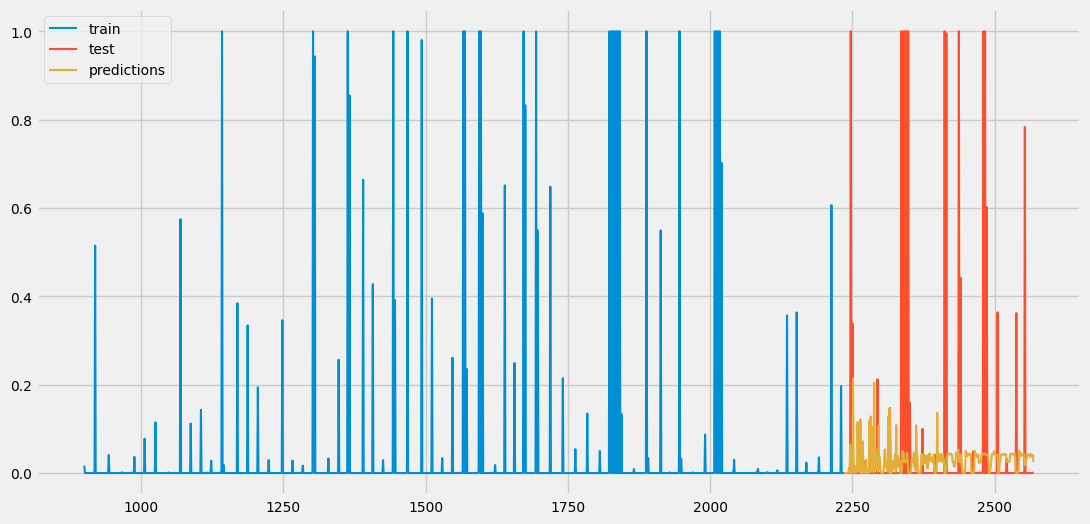

In [ ]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
data_train['Interarrival_scaled'].plot(ax=ax, label='train')
data_test['Interarrival_scaled'].plot(ax=ax, label='test')
predictions_base.plot(ax=ax, label='predictions')
ax.legend()

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
    y_true=data_test['Interarrival_scaled'],
    y_pred=predictions_base
)
print(f"Base Test error (MSE): {error_mse}")

Test error (MSE): 0.03781154318990143
